In [2]:
import pandas as pd
from paquo.projects import QuPathProject

from pathlib import Path
from paquo.projects import QuPathProject
from paquo.images import QuPathImageType
from paquo.classes import QuPathPathClass
from shapely.geometry import Point, Polygon, MultiPoint
import numpy as np
import matplotlib.pyplot as plt
from distutils.dir_util import copy_tree
import glob
import numpy as np
from collections import defaultdict
import pickle


In [2]:
def get_all_projectQuPath_metadata(root_path):

    
    meta_list = glob.glob(root_path + '/*Metadata_information.csv')
    print(meta_list)
    project_by_image = {}
    main_df = pd.DataFrame()
    for path in meta_list:
        last_slash_pos = path.rfind('/')
        project_dir = path[:last_slash_pos + 1]
        qpproj_path = glob.glob(project_dir + '*.qpproj')[0] 
        df = pd.read_csv(path, index_col=0)
        df['qpproj'] = qpproj_path
        df_analyse = df[df.Analyze == True]
        #df_analyse = df
        main_df = pd.concat([main_df, df_analyse])
    main_df = main_df.reset_index(drop=True)
    return main_df

In [3]:
def get_qupath_project_by_image_name(dataset, image_name : str, root_path=None) ->str:

    project_name =  dataset[dataset['Image Name'].str.contains(image_name)]['qpproj'].iloc[0]
    return project_name
    if root_path is not None:
        nissl_id = project_name[project_name.find('Nissl'):]
        project_name = root_path + nissl_id + '/' + project_name
        project_name = project_name
    return project_name

In [4]:
#root_path ='/gpfs/bbp.cscs.ch/project/proj53/LayerBoundariesProject/Analysis/'
root_path = '/gpfs/bbp.cscs.ch/project/proj53/LayerBoundariesProject/Analysis/Nissl_6/ProjectQuPath_1449922_RH_Nissl_6_MPtA/'
#root_path ='/tmp/'
meta_dataset = get_all_projectQuPath_metadata(root_path)
meta_dataset

['/gpfs/bbp.cscs.ch/project/proj53/LayerBoundariesProject/Analysis/Nissl_6/ProjectQuPath_1449922_RH_Nissl_6_MPtA/ProjectQuPath_1449922_RH_Nissl_6_WithMPtA.qpproj_Metadata_information.csv']


,Image Name,Exclude,Analyze,Distance to midline,Comment,qpproj
0,SLD_0000735.vsi-20x_03,False,True,2.60mm,0,/gpfs/bbp.cscs.ch/project/proj53/LayerBoundari...
1,SLD_0000735.vsi-20x_04,False,True,2.55mm,0,/gpfs/bbp.cscs.ch/project/proj53/LayerBoundari...
2,SLD_0000735.vsi-20x_05,False,True,2.50mm,0,/gpfs/bbp.cscs.ch/project/proj53/LayerBoundari...
3,SLD_0000735.vsi-20x_06,False,True,2.45mm,0,/gpfs/bbp.cscs.ch/project/proj53/LayerBoundari...
4,SLD_0000736.vsi-20x_01,False,True,2.40mm,0,/gpfs/bbp.cscs.ch/project/proj53/LayerBoundari...
5,SLD_0000736.vsi-20x_02,False,True,2.35mm,0,/gpfs/bbp.cscs.ch/project/proj53/LayerBoundari...
6,SLD_0000736.vsi-20x_03,False,True,2.30mm,0,/gpfs/bbp.cscs.ch/project/proj53/LayerBoundari...
7,SLD_0000736.vsi-20x_04,False,True,2.25mm,0,/gpfs/bbp.cscs.ch/project/proj53/LayerBoundari...
8,SLD_0000737.vsi-20x_01,False,True,2.20mm,0,/gpfs/bbp.cscs.ch/project/proj53/LayerBoundari...
9,SLD_0000737.vsi-20x_02,False,True,2.15mm,0,/gpfs/bbp.cscs.ch/project/proj53/LayerBoundari...


In [5]:
#qupath_project_root_path = '/media/LNMC/LBR_Analysis/WithPredictions/'
qupath_project_root_path = root_path



pixel_size = 0.3460130331522824

layers_color = {"Layer 1": "#ff0000"
            , "Layer 2":"#ff0099"
            , "Layer 3":"#cc00ff"
            , "Layer 2/3":"#751402"
            , "Layer 4":"#3300ff"
            , "Layer 5":"#0066FF"
            , "Layer 6 a":"#00ffff"
            , "Layer 6 b":"#00ff66"
           }

In [12]:
#with_prediction_list = glob.glob('/gpfs/bbp.cscs.ch/project/proj53/LayerBoundariesProject/Production/20231102/datasets/Exported_Features/Dataframes/For_prediction/01122024/Predictions/*')
with_prediction_list = glob.glob('/gpfs/bbp.cscs.ch/project/proj53/LayerBoundariesProject/Production/2024/MPtA/ProjectQuPath_1449922_RH_Nissl_6_MPtA/prediction/*.csv')
with_prediction_list
main_df_with_pred = pd.DataFrame()
for path in with_prediction_list:
    df = pd.read_csv(path)#, index_col=0)
    main_df_with_pred = pd.concat([main_df_with_pred, df])
main_df_with_pred = main_df_with_pred.reset_index(drop=False)    

def remove_space(a):
    return a.replace(' ','')

main_df_with_pred['Image'] = main_df_with_pred.apply(lambda row: remove_space(row['Image']), axis=1)

In [14]:
image_per_projects = defaultdict(list)
df1 = main_df_with_pred.drop_duplicates(subset=["Image"], keep="first")
for image_name in df1['Image']:
    image_name = image_name.replace(' ', '')
    qupath_project = get_qupath_project_by_image_name(meta_dataset, image_name, qupath_project_root_path)
    print(f'image name: { image_name}')
    image_per_projects[qupath_project].append(image_name)



image name: SLD_0000735.vsi-20x_05
image name: SLD_0000737.vsi-20x_01
image name: SLD_0000737.vsi-20x_02
image name: SLD_0000738.vsi-20x_01
image name: SLD_0000736.vsi-20x_01
image name: SLD_0000737.vsi-20x_03
image name: SLD_0000736.vsi-20x_04
image name: SLD_0000736.vsi-20x_02
image name: SLD_0000735.vsi-20x_03
image name: SLD_0000738.vsi-20x_03
image name: SLD_0000735.vsi-20x_04
image name: SLD_0000738.vsi-20x_02
image name: SLD_0000735.vsi-20x_06
image name: SLD_0000736.vsi-20x_03


In [15]:
done = []
#nb_images = len(image_names)
#for image_name in image_names:
#    print(f' search {image_name} ')

#    qupath_project = get_qupath_project_by_image_name(dataset, image_name, qupath_project_root_path)

#    print(f'Image name {image_name}, qupath {qupath_project}')

for qupath_project in image_per_projects.keys():
    
    print(f'Open project {qupath_project}')
    with QuPathProject(qupath_project, mode='r+') as qp:
        print(f'process {image_per_projects[qupath_project]}')
        for image_name in image_per_projects[qupath_project]:
            image_ml_result = main_df_with_pred[main_df_with_pred['Image']==image_name]
            annotations = []
            for index, layer in enumerate(["Layer 1", "Layer 2", "Layer 3", "Layer 2/3",  "Layer 4", "Layer 5", "Layer 6 a", "Layer 6 b"]):
                layer_points = image_ml_result[image_ml_result['RF_prediction'] == layer][['Centroid X µm', 'Centroid Y µm']].to_numpy()
                layer_points = layer_points / pixel_size
                if layer_points.size > 0:
                    annotations.append({ layer: MultiPoint(layer_points)})
            assert len(annotations) > 0
            found = False
            for image in qp.images:
                print(f'INFO image {image}')
                image_name_with_space = image_name.replace('-', ' - ')
                if image.image_name.find(image_name_with_space) > -1:
                    for index, annotation in enumerate(annotations):
                        for name, roi in annotation.items():
                            path_class = QuPathPathClass(name = name + '_prediction', color=layers_color[name])

                            annotation = image.hierarchy.add_annotation(roi=roi, path_class=path_class)
                    found = True
                    done.append(image_name)
                if found:
                    break
        print(f'Close project')
    
    print(f'project closed')        

    print('INFO: Done')


    

Open project /gpfs/bbp.cscs.ch/project/proj53/LayerBoundariesProject/Analysis/Nissl_6/ProjectQuPath_1449922_RH_Nissl_6_MPtA/ProjectQuPath_1449922_RH_Nissl_6_WithMPtA.qpproj
process ['SLD_0000735.vsi-20x_05', 'SLD_0000737.vsi-20x_01', 'SLD_0000737.vsi-20x_02', 'SLD_0000738.vsi-20x_01', 'SLD_0000736.vsi-20x_01', 'SLD_0000737.vsi-20x_03', 'SLD_0000736.vsi-20x_04', 'SLD_0000736.vsi-20x_02', 'SLD_0000735.vsi-20x_03', 'SLD_0000738.vsi-20x_03', 'SLD_0000735.vsi-20x_04', 'SLD_0000738.vsi-20x_02', 'SLD_0000735.vsi-20x_06', 'SLD_0000736.vsi-20x_03']
INFO image ImageEntry(image_name='SLD_0000735.vsi - 20x_03')
INFO image ImageEntry(image_name='SLD_0000735.vsi - 20x_04')
INFO image ImageEntry(image_name='SLD_0000735.vsi - 20x_05')
15:28:43.931 [main] [DEBUG] q.lib.objects.classes.PathClass - Creating PathClass with name 'Layer 1_prediction'
15:28:48.545 [main] [DEBUG] q.lib.objects.classes.PathClass - Creating PathClass with name 'Layer 2_prediction'
15:28:48.548 [main] [DEBUG] q.lib.objects.class

In [23]:
from layer_recognition.ml.utils import image_to_df
import pickle
import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
with open('/home/jacquemi/Downloads/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

In [7]:
image_names = ['Features_SLD_0000735.vsi-20x_03.csv']
pred_dir = '/gpfs/bbp.cscs.ch/project/proj53/LayerBoundariesProject/Production/2024/MPtA/ProjectQuPath_1449922_RH_Nissl_6_MPtA/converted/'

In [10]:
df = pd.read_csv(pred_dir + image_names[0])

In [11]:
df_copy = df.copy(deep=True)

In [18]:
df_copy[["Smoothed: 50 µm: Distance to annotation with Outside Pia µm", "Distance to annotation with Outside Pia µm", "Centroid Y µm"]] = scaler.transform(df_copy[["Smoothed: 50 µm: Distance to annotation with Outside Pia µm", "Distance to annotation with Outside Pia µm", "Centroid Y µm"]])


In [19]:
df

,Unnamed: 0,Image,Expert_layer,Centroid X µm,Centroid Y µm,Area µm^2,Length µm,Circularity,Solidity,Max diameter µm,Min diameter µm,Hematoxylin: Mean,Hematoxylin: Median,Hematoxylin: Min,Hematoxylin: Max,Hematoxylin: Std.Dev.,DAB: Mean,DAB: Median,DAB: Min,DAB: Max,DAB: Std.Dev.,Distance to annotation with Outside Pia µm,Distance to annotation with Other µm,Distance to annotation with MPtA µm,Delaunay: Num neighbors,Delaunay: Mean distance,Delaunay: Median distance,Delaunay: Max distance,Delaunay: Min distance,Delaunay: Mean triangle area,Delaunay: Max triangle area,Smoothed: 50 µm: Area µm^2,Smoothed: 50 µm: Length µm,Smoothed: 50 µm: Circularity,Smoothed: 50 µm: Solidity,Smoothed: 50 µm: Max diameter µm,Smoothed: 50 µm: Min diameter µm,Smoothed: 50 µm: Hematoxylin: Mean,Smoothed: 50 µm: Hematoxylin: Median,Smoothed: 50 µm: Hematoxylin: Min,Smoothed: 50 µm: Hematoxylin: Max,Smoothed: 50 µm: Hematoxylin: Std.Dev.,Smoothed: 50 µm: DAB: Mean,Smoothed: 50 µm: DAB: Median,Smoothed: 50 µm: DAB: Min,Smoothed: 50 µm: DAB: Max,Smoothed: 50 µm: DAB: Std.Dev.,Smoothed: 50 µm: Distance to annotation with Outside Pia µm,Smoothed: 50 µm: Distance to annotation with Other µm,Smoothed: 50 µm: Distance to annotation with MPtA µm,Smoothed: 50 µm: Delaunay: Num neighbors,Smoothed: 50 µm: Delaunay: Mean distance,Smoothed: 50 µm: Delaunay: Median distance,Smoothed: 50 µm: Delaunay: Max distance,Smoothed: 50 µm: Delaunay: Min distance,Smoothed: 50 µm: Delaunay: Mean triangle area,Smoothed: 50 µm: Delaunay: Max triangle area,Smoothed: 50 µm: Nearby detection counts,mean_diameter,neighbors,neighbor_mean,exclude_for_density
0,0,SLD_0000735.vsi - 20x_03,Not applicable,10774.0,1935.1,316.7925,72.3883,0.7597,0.9304,22.9109,19.2553,0.4358,0.4412,0.2071,1.0009,0.0974,-0.0446,-0.0460,-0.1215,0.0386,0.0217,821.9855,0,0.0000,7.0,17.6318,17.5425,24.2683,9.9571,121.3464,241.6811,91.7038,36.8504,0.7394,0.9248,12.7799,9.0695,0.3743,0.3695,0.1992,0.6886,0.0824,-0.0294,-0.0306,-0.0838,0.0405,0.0214,819.6769,0.0,0.0000,6.0332,16.7229,15.8491,25.1867,9.7810,112.1870,213.6140,31.0,21.08310,[ 0 6262 4349 1252 1241 2390],11.650317,False
1,1,SLD_0000735.vsi - 20x_03,Not applicable,11476.3,1185.3,0.0011,0.6566,0.0322,1.0000,0.3262,0.0034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0,0.0016,8.0,103.9722,50.6370,367.5547,11.8000,400.1419,927.8060,38.9298,21.1450,0.5715,0.9532,7.3470,4.9274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.3138,0.0,0.0004,5.7375,42.4466,29.1172,116.0314,10.4208,221.0656,480.1525,8.0,0.16480,[ 1 3923 256 6468 5699 5551],6.442742,False
2,2,SLD_0000735.vsi - 20x_03,Not applicable,10529.4,1866.1,289.4390,71.0117,0.7213,0.9497,25.8350,15.2236,0.3902,0.3913,0.1440,0.8021,0.1252,-0.0369,-0.0393,-0.1275,0.0489,0.0288,815.2214,0,0.0000,7.0,20.0854,19.6486,37.5173,9.7729,158.8409,419.6924,78.7898,33.5280,0.7264,0.9363,12.0878,7.5985,0.3679,0.3605,0.2023,0.6618,0.0831,-0.0292,-0.0308,-0.0851,0.0444,0.0227,816.3382,0.0,0.0000,5.9706,16.6811,15.3765,28.1735,8.3711,108.5454,239.9810,33.0,20.52930,[ 2 4432 2297 4547 4635 6224],9.974450,False
3,3,SLD_0000735.vsi - 20x_03,Not applicable,11054.0,1947.8,284.5345,67.2154,0.7914,0.9436,22.0885,18.3369,0.3318,0.3420,0.1232,0.5787,0.0911,-0.0238,-0.0279,-0.0862,0.0617,0.0250,826.5441,0,0.0000,6.0,16.8917,15.3068,25.7029,12.0073,109.0912,187.5922,99.0759,39.0702,0.7274,0.9283,13.6111,9.3528,0.3180,0.3118,0.1672,0.5763,0.0740,-0.0202,-0.0216,-0.0754,0.0513,0.0215,825.1223,0.0,0.0000,5.9067,16.3731,16.0273,23.9234,9.5004,110.2551,198.7706,33.0,20.21270,[ 3 2693 6067 870 1542 414],12.415542,False
4,4,SLD_0000735.vsi - 20x_03,Not applicable,10918.5,1967.3,281.8960,66.6572,0.7973,0.9606,23.0829,17.5058,0.4038,0.4078,0.1665,0.6391,0.0977,-0.0440,-0.0457,-0.1017,0.0279,0.0223,850.2206,0,0.0000,7.0,25.6983,26.3721,31.1471,13.3008,191.8022,350.2214,118.9844,42.1419,0.7563,0.9427,14.5896,10.5623,0.3603,0.3530,0.1772,0.6336,0.0903,-0.0281,-0.0294,-0.0878,0.0489,0.0232,847.8834,0.0,0.0000,6.1691,18.9544,18.2366,27.9530,10.7690,13

In [21]:
orig = df["Distance to annotation with Outside Pia µm"].to_numpy()

In [22]:
scaled = df_copy["Distance to annotation with Outside Pia µm"].to_numpy()

In [31]:
x=df["Centroid X µm"].to_numpy()
y=df["Centroid Y µm"].to_numpy()

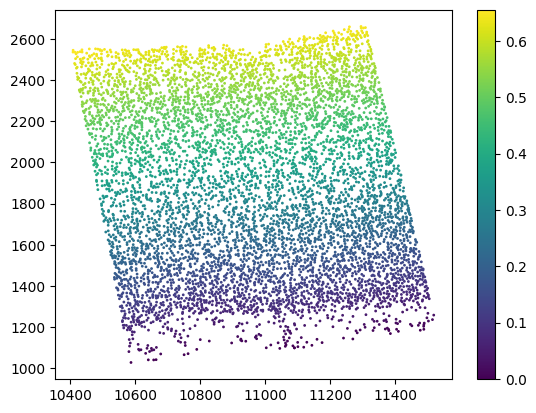

In [36]:
plt.scatter(x,y, s=1,c=scaled)
plt.colorbar()

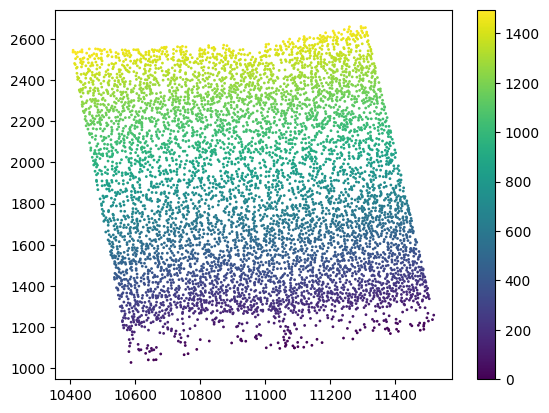

In [37]:
plt.scatter(x,y, s=1,c=orig)
plt.colorbar()